In [1]:
# Ignore unneccessary warning
import warnings
import sys
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Load packages
import numpy as np
import os
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.datasets import cifar10
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Activation, Conv2D, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input
from keras import backend as K
from keras import regularizers
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


## Labelled Faces in the Wild Dataset

In [2]:
PATH = 'lfw_funneled/'
os.listdir(PATH)[:5]

['Ashton_Kutcher',
 'Lindsay_Benko',
 'Val_Ackerman',
 'John_Brady',
 'Anthony_Garotinho']

In [3]:
# Find all face images path in wild dataset
img_paths = []
for (dir_path, _, filenames) in os.walk(PATH):
    for filename in filenames:
        if filename.endswith('.jpg'):
            img_paths.append(f'{dir_path}/{filename}')

In [4]:
# Pick randomly 7000 out of face images
nb_images_pickup = 7000
seed = 123
image_width = image_height = 32
random.seed(seed)
img_paths_picked = random.sample(img_paths, nb_images_pickup)

In [5]:
# Resize dimension of face images to (32, 32, 3)
def load_wild_dataset(img_paths, image_width=32, image_height=32):
    wild_dataset = np.zeros((nb_images_pickup, image_width, image_height, 3))
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path)
        img.thumbnail((image_width, image_height))
        wild_dataset[i] = img
        
    return wild_dataset

wild_datsaet = load_wild_dataset(img_paths_picked, image_width, image_height)

In [6]:
print('Finally dimension of wild dataset:', wild_datsaet.shape)

Finally dimension of wild dataset: (7000, 32, 32, 3)


## Cifar10

In [8]:
# Load Cifa10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
# Concatenate the wild dataset and cifar10
x_set = np.concatenate((wild_datsaet, x_train, x_test), axis=0)
print('Training dimension:', x_set.shape)

Training dimension: (67000, 32, 32, 3)


In [10]:
# Convert label to one-hot vector
nb_classes = len(np.unique(y_train)) + 1
y_train_oh = to_categorical(y_train, num_classes=nb_classes)
y_test_oh = to_categorical(y_test, num_classes=nb_classes)

In [11]:
# Add face human to label #10
y_wild_dataset = np.zeros((len(wild_datsaet), len(np.unique(y_train)) + 1))
y_wild_dataset[:, 10] = 1
y_set = np.concatenate((y_wild_dataset, y_train_oh, y_test_oh), axis=0)
print('Dimension of label:', y_set.shape)

Dimension of label: (67000, 11)


In [12]:
# Split training and test set with test size of 0.2
X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.2, random_state=seed)

## Train model

In [14]:
def base_model(input_shape):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

In [17]:
model = base_model(input_shape=x_set[0].shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [38]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)
 
#training
batch_size = 64
 
opt_rms = optimizers.rmsprop(lr=0.01,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=50, validation_data=(X_test,y_test))
# ,callbacks=[LearningRateScheduler(lr_schedule)]     steps_per_epoch=x_train.shape[0] // batch_size,

Epoch 1/50
838/838 [==============================] - 34s 40ms/step - loss: 1.6087 - acc: 0.4562 - val_loss: 1.4359 - val_acc: 0.5322
Epoch 2/50
838/838 [==============================] - 31s 38ms/step - loss: 1.1403 - acc: 0.6130 - val_loss: 1.1097 - val_acc: 0.6425
Epoch 3/50
838/838 [==============================] - 32s 38ms/step - loss: 0.9787 - acc: 0.6762 - val_loss: 0.8656 - val_acc: 0.7221
Epoch 4/50
838/838 [==============================] - 31s 38ms/step - loss: 0.8934 - acc: 0.7093 - val_loss: 0.9863 - val_acc: 0.6893
Epoch 5/50
838/838 [==============================] - 32s 38ms/step - loss: 0.8425 - acc: 0.7324 - val_loss: 0.8566 - val_acc: 0.7460
Epoch 6/50
838/838 [==============================] - 32s 38ms/step - loss: 0.8071 - acc: 0.7472 - val_loss: 0.9587 - val_acc: 0.7140
Epoch 7/50
838/838 [==============================] - 31s 37ms/step - loss: 0.7768 - acc: 0.7606 - val_loss: 0.7018 - val_acc: 0.7904
Epoch 8/50
838/838 [==============================] - 32s 38ms

In [19]:
# model.load_weights('reference04.h5')

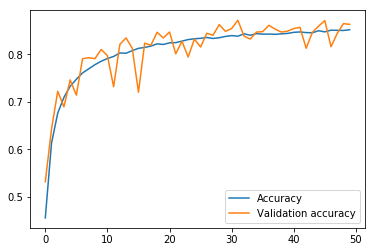

In [39]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Accuracy', 'Validation accuracy'], loc='lower right')

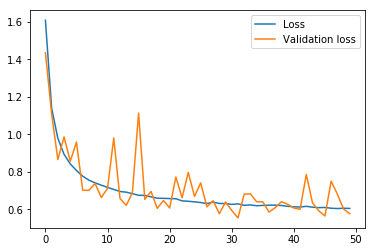

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Loss', 'Validation loss'], loc='upper right')

## Analyze the model

### Confusion matrix on test set

In [21]:
# Predict X_test
y_predict = model.predict(X_test, batch_size=64)

In [22]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [23]:
# Label name of cifar10 and face_human
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck", "face_human"]

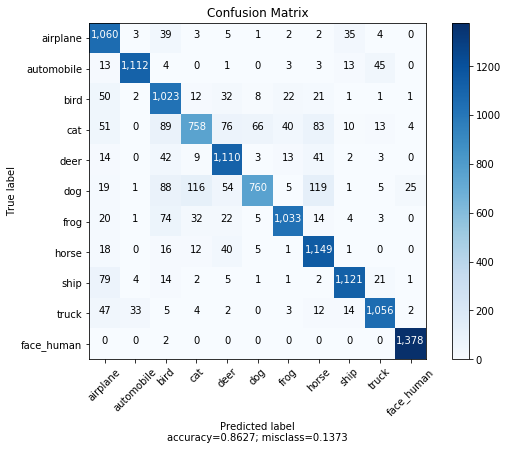

In [25]:
# Plot confusion matrix
plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_predict, axis=1)), normalize=False, target_names=label_names, title="Confusion Matrix")

### Predict my images

In [31]:
def predict_data(img_path):
    data = cv2.imread(img_path)
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    plt.imshow(data)
    data = cv2.resize(data, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
    data = img_to_array(data)
    data = data[np.newaxis, :]
    data_predict = model.predict(x = data)
    print('It is', label_names[np.argmax(data_predict, axis=1)[0]], 'with probability of', np.max(data_predict, axis=1)[0])

It is face_human with probability of 1.0


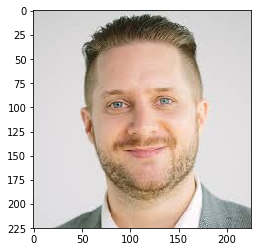

In [32]:
predict_data('face.jpg')

It is airplane with probability of 0.99977607


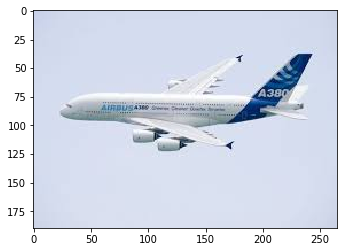

In [33]:
predict_data('airplane.jpg')

It is automobile with probability of 0.6271159


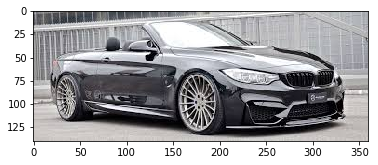

In [34]:
predict_data('automobile.jpg')

It is bird with probability of 0.9998714


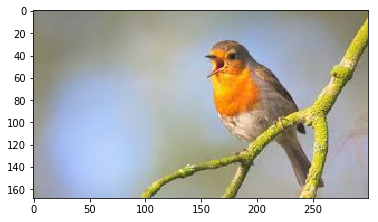

In [35]:
predict_data('bird.jpg')

It is deer with probability of 0.3684719


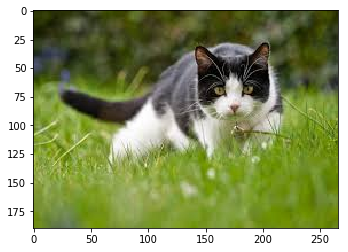

In [36]:
predict_data('cat.jpg')

It is bird with probability of 0.4120122


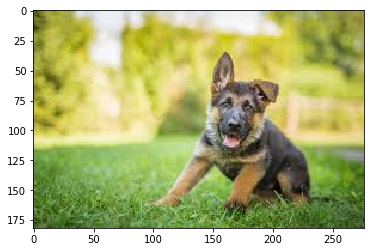

In [37]:
predict_data('dog.jpg')

In [ ]:
predict_data('airplane.jpg')

In [ ]:
predict_data('airplane.jpg')